# Earthquake seismology with DAS

In [1]:
import h5py
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import numpy as np
import datetime
import pandas as pd



from dasquakes import sintela_to_datetime, open_sintela_file, get_file_number, local_earthquake_quicklook

import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

### Read a CSV file from PNSN.org

In [7]:
event_df = pd.read_csv('pnsn_event_export_20220616.csv')

### Choose an event to analyze

In [ ]:
catalog_index = 2
t0 = datetime.datetime.strptime(event_df.iloc[catalog_index]['Time UTC'],"%Y/%m/%d %H:%M:%S")

event_df.iloc[catalog_index]

In [3]:
data,dates,attrs = open_sintela_file('seadasn',t0,'/data/data0/seadasn/',number_of_files=2)
x_max=data.shape[1] * attrs['SpatialSamplingInterval']

/data/data0/seadasn/seadasn_2022-05-17_08-07*.h5


In [4]:
low_cut = 1
hi_cut = 10

b,a = butter(2,(low_cut,hi_cut),'bp',fs=attrs['MaximumFrequency']*2)
data_filt = filtfilt(b,a,data,axis=0)

In [5]:
client = Client("IRIS")

t1 = UTCDateTime( t0.strftime("%Y-%m-%dT%H:%M:%S") )
dt = datetime.timedelta(minutes=1)
t2 = UTCDateTime( (t0+dt).strftime("%Y-%m-%dT%H:%M:%S") )

st = client.get_waveforms("UW", "NOWS", "--", "HNN", t1, t2, attach_response=True)
st.decimate(5, strict_length=False, no_filter=False) #everything should be at 40Hz now
st2 = client.get_waveforms("IU", "COR", "00", "BH1", t1, t2, attach_response=True)

pre_filt = (low_cut/2, low_cut, hi_cut, hi_cut*2)
st.remove_response(output='VEL', pre_filt=pre_filt)
st2.remove_response(output='VEL', pre_filt=pre_filt)

1 Trace(s) in Stream:
IU.COR.00.BH1 | 2022-05-17T08:07:34.019538Z - 2022-05-17T08:08:33.994538Z | 40.0 Hz, 2400 samples

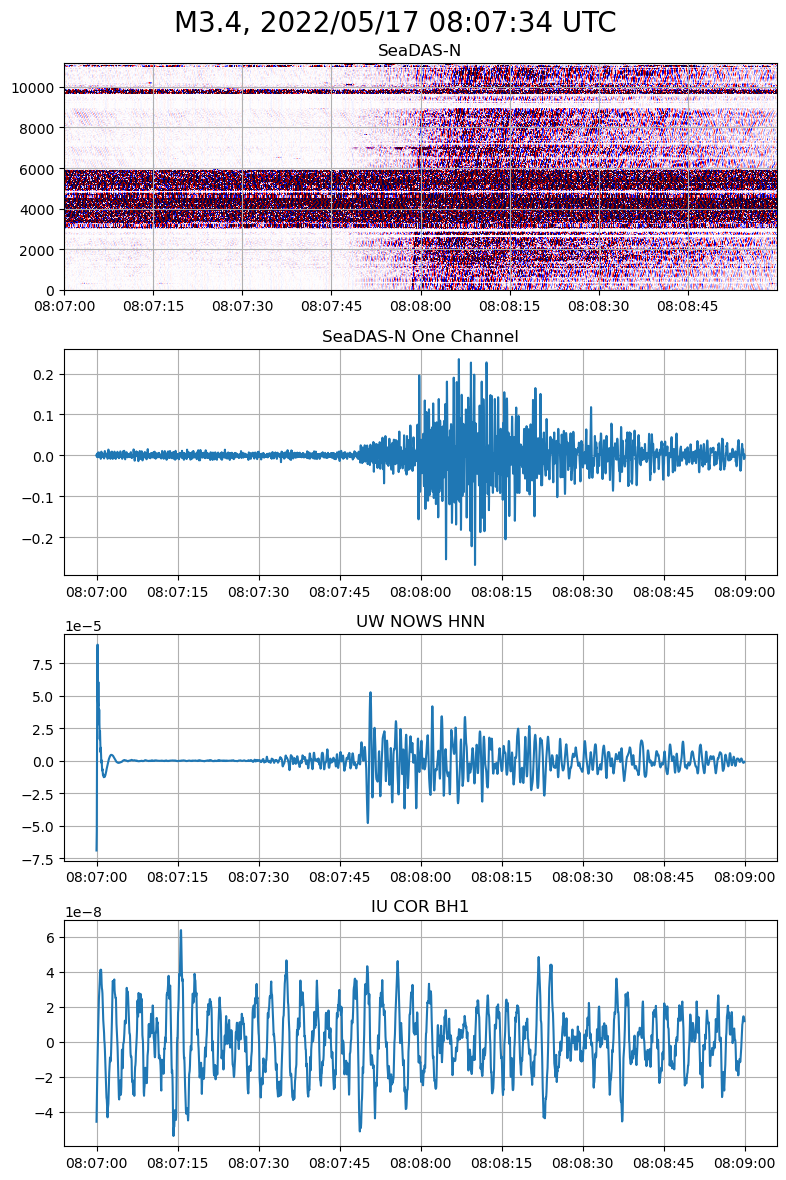

In [6]:
local_earthquake_quicklook(dates,data_filt,st,st2,x_max,event_df,catalog_index)